In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dfi = pd.read_csv(r"C:\Users\ayush\Downloads\NextBuy – your perfect purchase\DataSet\ratings_Beauty.csv")
df = dfi.drop('Timestamp', axis=1) #Dropping timestamp

In [7]:
counts = df['UserId'].value_counts()
df_filtered = df[df['UserId'].isin(counts[counts >= 60].index)]
print('The number of observations in the final data =', len(df_filtered))
print('Number of unique USERS in the final data = ', df_filtered['UserId'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_filtered['ProductId'].nunique())
df_filtered.head()

The number of observations in the final data = 22668
Number of unique USERS in the final data =  233
Number of unique PRODUCTS in the final data =  14163


,UserId,ProductId,Rating
5,AKJHHD5VEH7VG,0762451459,5.0
42,A22ZFXQE8AWPEP,1304482596,1.0
47,A22ZFXQE8AWPEP,1304482685,1.0
52,A22ZFXQE8AWPEP,1304495396,1.0
61,A22ZFXQE8AWPEP,1304511111,1.0


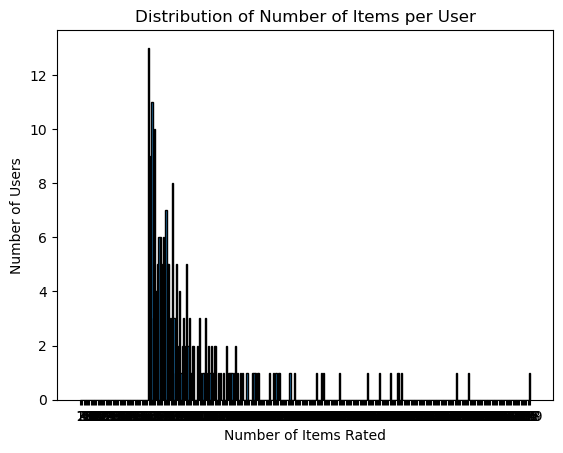

In [ ]:
# Count the number of items per user
items_per_user = df_filtered['UserId'].value_counts()

# Plot the histogram
plt.hist(items_per_user, bins=range(1, items_per_user.max() + 2), edgecolor='black', align='left')
plt.xlabel('Number of Items Rated')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Items per User')
plt.xticks(range(1, items_per_user.max() + 1))
plt.show()


In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
from pyspark.ml.feature import StringIndexer

# Initialize SparkSession
spark = SparkSession.builder.appName("UserItemMasking").getOrCreate()



# Set percentage of items to mask
percent_items_to_mask = 0.3

# Calculate the number of items rated by each user
df_filtered = df_filtered.withColumn("num_items", rank().over(Window.partitionBy("UserId")))

# Determine the number of items to mask for each user
df_filtered = df_filtered.withColumn(
    "num_items_to_mask",
    (col("num_items") * percent_items_to_mask).cast("int")
)

# Rank items for each user
user_window = Window.partitionBy("UserId").orderBy("ProductId")
df_filtered = df_filtered.withColumn("item_rank", rank().over(user_window))

# Index the UserId and ProductId columns
indexer_user = StringIndexer(inputCol='UserId', outputCol='userIndex').setHandleInvalid("keep")
indexer_item = StringIndexer(inputCol='ProductId', outputCol='itemIndex').setHandleInvalid("keep")

df_filtered = indexer_user.fit(df_filtered).transform(df_filtered)
df_filtered = indexer_item.fit(df_filtered).transform(df_filtered)

# Convert userIndex and itemIndex columns to integer type
df_filtered = df_filtered.withColumn('userIndex', col('userIndex').cast('integer')) \
                         .withColumn('itemIndex', col('itemIndex').cast('integer'))

# Split the data into training and testing datasets
train_df_rec = df_filtered.filter(col("item_rank") > col("num_items_to_mask"))
test_df_rec = df_filtered.filter(col("item_rank") <= col("num_items_to_mask"))

# Show the results
print("Training Data:")
train_df_rec.show()

print("Testing Data:")
test_df_rec.show()


PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.